In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd

from tqdm import tqdm
from itertools import combinations

In [2]:
import random

NUM_PAIRS = 200
POSITIVE_PORTION = 0.5

IDENTITIES_FOLDER = "/gpfs/gpfs0/r.karimov/IJB/aligned_data_for_fusion/big"
RESULT_META_DIR = "/gpfs/gpfs0/r.karimov/IJB/aligned_data_for_fusion/metadata_refuse_verification"

In [3]:
probes = []

In [4]:
# sum(len(os.listdir(os.path.join(IDENTITIES_FOLDER, dirr))) * (len(os.listdir(os.path.join(IDENTITIES_FOLDER, dirr))) - 1) / 2 for dirr in os.listdir(IDENTITIES_FOLDER))

In [5]:
def randomized_round(number):
    return int(number) + int(random.random() < (number % 1))


def sample_pairs_from_directory(prefix, directory, n_pairs):
    pairs = list(combinations(os.listdir(os.path.join(prefix, directory)), r=2))
    n_sampled_pairs = n_pairs if n_pairs < len(pairs) else len(pairs)
    pairs = [tuple(map(lambda x: os.path.join(directory, x), pair)) for pair in pairs]
    return random.sample(pairs, n_sampled_pairs)


def generate_positive_pairs(identities_dir, n_pairs):

    remaining_directories = sum(1 for _ in os.listdir(identities_dir))
    remaining_pairs = n_pairs

    positive_pairs = []

    directories = os.listdir(identities_dir)
    random.shuffle(directories)
    
    mean_pairs_from_directory = n_pairs / len(directories)
    sampled_pairs = 0
    
    for idx, directory in tqdm(enumerate(directories)):
        lack = idx * mean_pairs_from_directory - sampled_pairs
        lack = max(0, lack)
        
        needed_pairs_amount = randomized_round(lack + mean_pairs_from_directory)
        probes.append(needed_pairs_amount)
        new_pairs = sample_pairs_from_directory(identities_dir, directory, needed_pairs_amount)
        positive_pairs.extend(new_pairs)

        sampled_pairs += len(new_pairs)
        
    return positive_pairs


def generate_negative_pairs(identities_dir, n_pairs):
    negative_pairs = set()
    identities = list(os.listdir(identities_dir))
    i = 0
    while len(negative_pairs) < n_pairs:
        left, right = random.sample(identities, 2)
        potential_lefts = os.listdir(os.path.join(identities_dir, left))
        potential_rights = os.listdir(os.path.join(identities_dir, right))
        
        if len(potential_lefts) and len(potential_rights):
            left = os.path.join(left, random.choice(potential_lefts))
            right = os.path.join(right, random.choice(potential_rights))
            negative_pairs.add((left, right,))
            
        if i % 1000 == 0:
            sys.stdout.write("Sampled pairs : {}/{}...\t\r".format(len(negative_pairs), n_pairs))
    return list(negative_pairs)

In [6]:
# generate_negative_pairs(IDENTITIES_FOLDER, int(NUM_PAIRS * (1 - POSITIVE_PORTION)))

# generate_positive_pairs(IDENTITIES_FOLDER, int(NUM_PAIRS * POSITIVE_PORTION))

In [7]:
meta_path = os.path.join(RESULT_META_DIR, "pairs_" + str(NUM_PAIRS) + "_prob_" + str(POSITIVE_PORTION) + ".csv")
with open(meta_path, "w") as f:
    pairs = generate_positive_pairs(IDENTITIES_FOLDER, int(NUM_PAIRS * POSITIVE_PORTION))
    print("Positive pairs number :", len(pairs))    
    for pair in pairs:
        f.write(",".join((pair[0], pair[1], "1")) + "\n")
    pairs = generate_negative_pairs(IDENTITIES_FOLDER, int(NUM_PAIRS * (1 - POSITIVE_PORTION)))
    print("Negative pairs number :", len(pairs))
    for pair in pairs:
        f.write(",".join((pair[0], pair[1], "0")) + "\n")

3531it [00:20, 175.46it/s]

Positive pairs number : 103
Negative pairs number : 100


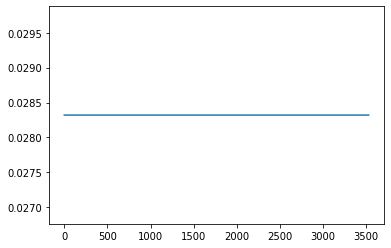

In [8]:
import matplotlib.pyplot as plt
    
plt.plot(probes)